In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

"""

OUTDATED FOR NOW, DO NOT USE

("not considered a priority" -Kielen, 2023 D:)

"""

#-------------------Inputs-------------------------------------------------------------
input_file = "Station Information.csv"
outerHull_file = "Outer Hull.csv" # Will be used for hydrostatic force and waterline calculation
DLF = 1.25 # Dead Load Factor
LLF = 1.3 # Live Load Factor
pad_male = 81.64 # Weight of male padder (kg)
pad_female = 68.03 # Weight of female paddler (kg)
water_den = 1000 # Density of water = 1000 kg/m^3
g = 9.81 # Gravity [m/s^2]
HF = 1.2 # Hydrostatic Force Factor
concrete_density = 1300 # [kg/m^3]
thickness = 25 # [mm]
#--------------------------------------------------------------------------------------
pad1_po = 1000 # Position of first paddler with respect to left end of canoe (mm)
pad2_po = 2000 # Position of second paddler with respect to left end of canoe (mm)
pad3_po = 4000 # Position of third paddler with respect to left end of canoe (mm)
pad4_po = 5000 # Position of fourth paddler with respect to left end of canoe (mm)
pad_first = pad_male # Choose between pad_male and pad_female
pad_second = pad_female # Choose between pad_male and pad_female
pad_third = pad_female # Choose between pad_male and pad_female
pad_fourth = pad_male # Choose between pad_male and pad_female
# Applies live load factor
pad1 = pad_first*LLF
pad2 = pad_second*LLF
pad3 = pad_third*LLF
pad4 = pad_fourth*LLF
#--------------------------------------------------------------------------------------

script_dir = os.path.abspath('data') # absolute file path in Jupyter
file_path = os.path.join(script_dir, input_file) # file path for the station information

# Get the canoe's volume and mass from the station info
canoe_info = pd.read_csv(file_path, header=None)
statVol = canoe_info[1][1:]
statMass = canoe_info[2]

# Get the outer hull coordinates from the input file
file_path = os.path.join(script_dir, outerHull_file)
out_coor = pd.read_csv(file_path, header=None)
x_out = out_coor[0]
y_out = out_coor[1]
z_out = out_coor[2]

# Convert Series to List
stat_Mass = []
for i in range(1,len(statMass),1):
    stat_Mass.append(float(statMass[i]))

stat_Vol = []
for i in range(1,len(statVol),1):
    stat_Vol.append(float(statVol[i]))

canoe_volume = np.sum(stat_Vol) # m^3
canoe_weight = np.sum(stat_Mass)*DLF # [kg]
total_weight = canoe_weight + pad1 + pad2 # [kg]

station_no = x_out.nunique() # number of stations
station = x_out.unique() # location of each station


In [2]:
# Hydrostatic Force and Moment

hydro_x = []
hydro_y = []
moment = []

# Loop through each station
# The loop ends at station_no - 2 because each loop uses the kth and the (k+1)th station
for k in range(1,station_no-2,1):

    # Coordinates of points in the outer frame sharing an X-coordinate with the current station
    X1_value = station[k]
    Y1 = []
    Z1 = []

    # Coordinates of points in the outer frame sharing an X-coordinate with the next station
    X2_value = station[k+1]
    Y2 = []
    Z2 = []

    # Loop through each x coordinate in the outer hull
    for i in range(0,len(x_out),1):

        # If the coordinate is aligned with the second station on the X-axis, store this XYZ coordinate
        if x_out[i] == X1_value:
            Y1.append(y_out[i])
            Z1.append(z_out[i])

        # Otherwise, if the coordinate is aligned with the second station on the X-axis, store this XYZ coordinate
        elif x_out[i] == X2_value:
            Y2.append(y_out[i])
            Z2.append(z_out[i])
    
    # TODO: Transverse Loop
    stat_hydro_x = []
    stat_hydro_y = []
    moment_y = []
    moment_x = []
    n = int((len(Y1)-1)/2)
    for j in range(0,n,1):
        X = abs(X2_value - X1_value)
        Y = thickness
        Z = abs(Z1[j+1])+ abs(Z2[j+1])/2
        
        Y_value = (abs(Y1[j])+ abs(Y1[j+1]) + abs(Y2[j]) + abs(Y2[j+1]))/4
        Z_value = (abs(max(Z2))+abs(max(Z1)))/2 - (abs(Z1[j])+abs(Z1[j+1])+abs(Z2[j])+abs(Z2[j+1]))
        
        stat_hydro_yi = water_den*g*(Z/1000)*(Y/1000)*(X/1000) # [N]
        
        area1 = (abs(Y1[j])+abs(Y1[j+1]))*abs(Z1[j]-Z1[j+1])/2
        area2 = (abs(Y2[j])+abs(Y2[j+1]))*abs(Z2[j]-Z2[j+1])/2
        volume = X*(area1 + area2)/2
        
        stat_hydro = water_den*g*volume/10**9 # [N]
        
        if stat_hydro**2 - stat_hydro_yi**2 >= 0:
            stat_hydro_xi = abs(stat_hydro**2 - stat_hydro_yi**2)**0.5 # [N]
        else:
            stat_hydro_xi = -abs(stat_hydro**2 - stat_hydro_yi**2)**0.5 # [N]
        
        stat_hydro_x.append(stat_hydro_xi)
        stat_hydro_y.append(stat_hydro_yi)
        moment_y.append(stat_hydro_yi*Y_value/1000)
        moment_x.append(stat_hydro_xi*Z_value/1000)
    
    hydro_x.append(np.sum(stat_hydro_x))
    hydro_y.append(np.sum(stat_hydro_y))
    moment.append((-1)*(np.sum(moment_y)+np.sum(moment_x)))

    

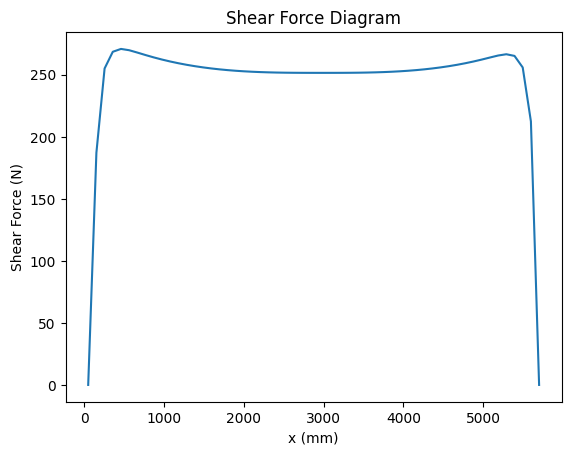

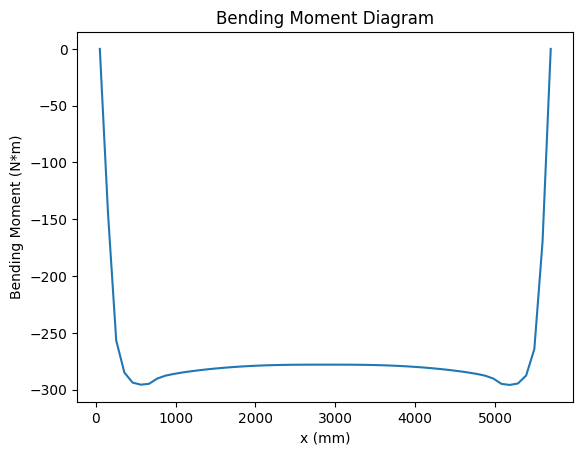

Maximum positive shear is  270.83310866516933 N.
Maximum negative shear is  0 N.
Maximum positive moment is  0 Nm.
Maximum negative moment is  -295.9046515682541 Nm.


In [3]:
# Plot SFD and BMD
stat_x = []
for i in range(0,len(station)-1,1):
    stat_x.append((station[i]+station[i+1])/2)

x = []
shear = []

for j in range(0,len(stat_x)-2,1):
    shear_force  = hydro_y[j]*HF +(-1)*stat_Vol[j]*concrete_density*g*DLF/2
    shear.append(shear_force)

shear.insert(0,0)
shear.append(0)

plt.plot(stat_x,shear)
plt.title('Shear Force Diagram')
plt.xlabel('x (mm)')
plt.ylabel('Shear Force (N)')
plt.show()

moment.append(0)
moment.insert(0,0)

plt.plot(stat_x,moment)
plt.title('Bending Moment Diagram')
plt.xlabel('x (mm)')
plt.ylabel('Bending Moment (N*m)')
plt.show()

shear_max_index = hydro_x.index(max(hydro_x))

print('Maximum positive shear is ', max(shear), 'N.')
print('Maximum negative shear is ', min(shear), 'N.')
print('Maximum positive moment is ', max(moment), 'Nm.')
print('Maximum negative moment is ', min(moment), 'Nm.')
